**Part 1 ‑ Exploratory data analysis**

In [1]:
import pandas as pd
import numpy as np
import io
import json
from google.colab import files
import datetime
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

In [2]:
uploaded = files.upload()

Saving logins.json to logins.json


In [3]:
logins = json.loads(uploaded['logins.json'].decode("utf-8"))

In [4]:
logins_df = pd.DataFrame(logins)
logins_df.head()

,login_time
0,1970-01-01 20:13:18
1,1970-01-01 20:16:10
2,1970-01-01 20:16:37
3,1970-01-01 20:16:36
4,1970-01-01 20:26:21


In [5]:
logins_df['login_time'] = pd.to_datetime(logins_df['login_time'], format='%Y-%m-%d %H:%M:%S')
logins_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 93142 entries, 0 to 93141
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   login_time  93142 non-null  datetime64[ns]
dtypes: datetime64[ns](1)
memory usage: 727.8 KB


In [6]:
logins_15mcount = logins_df.resample('H', on='login_time', offset='15min').size().reset_index(name='15m count')
logins_15mcount

,login_time,15m count
0,1970-01-01 19:15:00,2
1,1970-01-01 20:15:00,23
2,1970-01-01 21:15:00,17
3,1970-01-01 22:15:00,28
4,1970-01-01 23:15:00,52
...,...,...
2443,1970-04-13 14:15:00,38
2444,1970-04-13 15:15:00,16
2445,1970-04-13 16:15:00,20
2446,1970-04-13 17:15:00,22


In [7]:
logins_15mcount.describe()

,15m count
count,2448.000000
mean,38.048203
std,30.820428
min,0.000000
25%,15.000000
50%,30.000000
75%,52.000000
max,217.000000


In [8]:
#25.5 days worth of data
2448/4/24

25.5

In [9]:
logins_hrcount = logins_df.resample('H', on='login_time').size().reset_index(name='login_time count')
logins_hrcount

,login_time,login_time count
0,1970-01-01 20:00:00,24
1,1970-01-01 21:00:00,9
2,1970-01-01 22:00:00,21
3,1970-01-01 23:00:00,58
4,1970-01-02 00:00:00,53
...,...,...
2442,1970-04-13 14:00:00,32
2443,1970-04-13 15:00:00,19
2444,1970-04-13 16:00:00,22
2445,1970-04-13 17:00:00,22


Text(0.5, 1.0, 'Frequency of trips every hour')

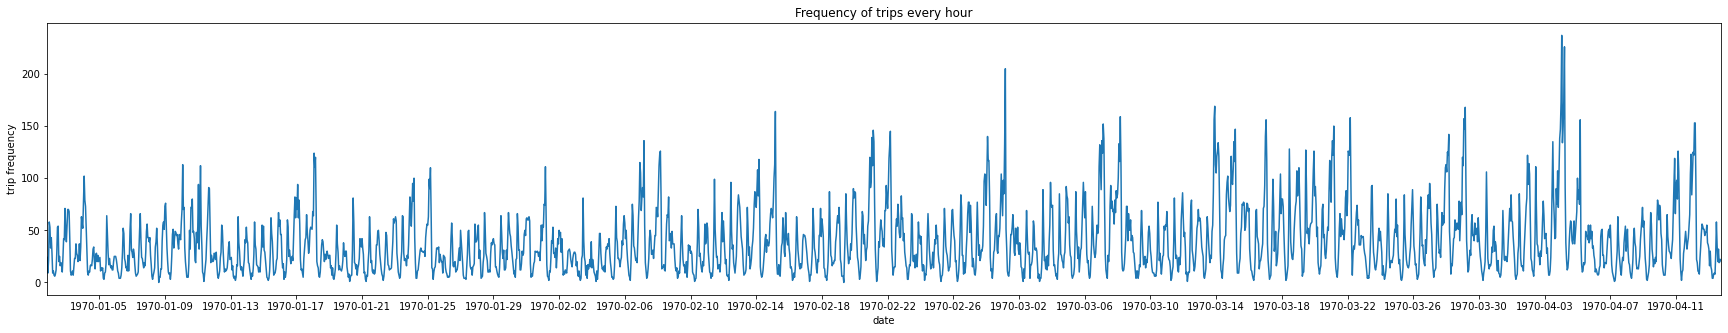

In [10]:
#Frequency of trips every hour
fig, ax = plt.subplots(figsize=(30, 5))
plt.plot('login_time', 'login_time count', data=logins_hrcount)
ax.xaxis.set_major_locator(mdates.DayLocator(interval=4))
ax.margins(x=0)
ax.set_xlabel('date')
ax.set_ylabel('trip frequency')
plt.title('Frequency of trips every hour')

In [11]:
logins_hrcount.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2447 entries, 0 to 2446
Data columns (total 2 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   login_time        2447 non-null   datetime64[ns]
 1   login_time count  2447 non-null   int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 38.4 KB


In [12]:
logins_hrcountagg = logins_hrcount.groupby(logins_hrcount['login_time'].dt.hour).sum().reset_index()
logins_hrcountagg.columns = ['hour', 'hr login_time count']
logins_hrcountagg.head(3)

,hour,hr login_time count
0,0,5993
1,1,6317
2,2,5800


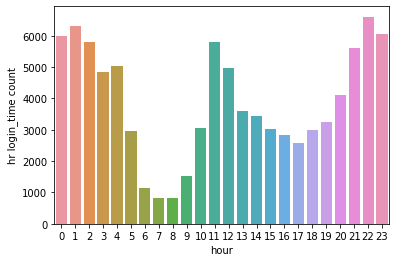

In [13]:
#over these 3.5 weeks, this is the total demand at each hour
sns.barplot(x='hour', y='hr login_time count', data=logins_hrcountagg)

In [14]:
rolling_trips = logins_hrcount['login_time count'].rolling(window=168, center=False)

In [15]:
logins_hrcount['rolling_trips'] = rolling_trips.mean()

Text(0.5, 1.0, 'Frequency of trips smoothed over 7 days')

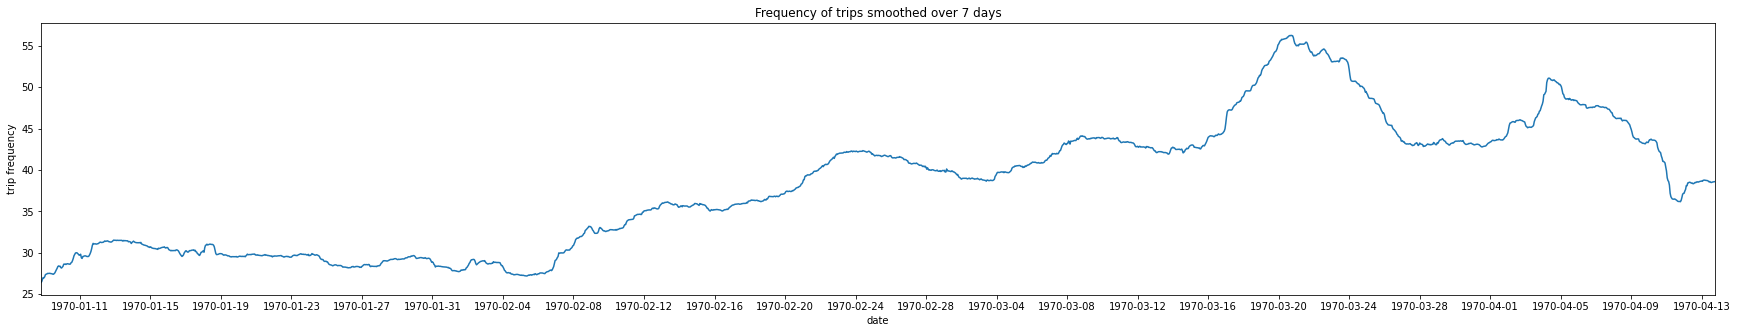

In [16]:
#Frequency of trips every hour smoothed over 7 days
fig, ax = plt.subplots(figsize=(30, 5))
plt.plot('login_time', 'rolling_trips', data=logins_hrcount)
ax.xaxis.set_major_locator(mdates.DayLocator(interval=4))
ax.margins(x=0)
ax.set_xlabel('date')
ax.set_ylabel('trip frequency')
plt.title('Frequency of trips smoothed over 7 days')

**Part 2 ‑ Experiment and metrics design**

*What would you choose as the key measure of success of this experiment in encouraging driver partners to serve both cities, and why would you choose this metric?*

Ultimately, Ultimate Inc. wants to make more money, which means more total time on the road of their drivers’ cars with passenger(s) inside.
I would choose a metric involving surges, either the avg_surge closest to 1.0 or surge_perc closest to 0.0. Hopefully, this would lead to an increase in total number of trips and trip duration, meaning more profit for Ultimate. That increase in profit would need to be more than the cost of paying off the toll charges.

To maximize the number and frequency of drivers (supply), drivers want the lowest pick up times. Surges are nice if they happen to be lucky enough to end a trip with a surge area close, but much more often, a ‘hot spot’ that will pay you extra from a surge is a decent drive away which just means wasted time and gas to get to these ‘hot spot’ pickup locations. So, overall, as a driver, you want to work most efficiently: have consistent trips with short pick up distances to make the most money. This is achieved by working at the busiest locations/times of day, perhaps avoiding toll charges, and of course, maximizing riders.

To maximize the number and frequency of riders (demand), riders will want the lowest wait times and the lowest prices (and quality service which we will assume as a given here). This way, they will choose an Ultimate trip over a trip with a rideshare competitor company, public transportation, private carpool options, or not taking the trip at all. A lower wait time and lower price is represented by lower surges.

Therefore, I would choose to target the metric of lowering surges to represent a balance of supply and demand. This would mean drivers are busier, passengers have lower wait times and would take more trips, and Ultimate would make more money.

Other factors such as maintaining driver quality, appeasing cancellations, Ultimate taking a consistent cut of trip payments are all assumed to be constant.


*Describe a practical experiment you would design to compare the effectiveness of the proposed change in relation to the key measure of success.*

I would, first, allow drivers the option to opt into the experiment. Of those drivers who opted in, split them into two groups, Group A, where everything functions as before (control) and Group B, where toll expenses were reimbursed (test).

Null Hypothesis: the surge percent (the percent of trips taken with surge multiplier > 1) of Group 1 is equal to the surge percent in Group 2

Alternate Hypothesis: the surge percent in Group 2 is significantly lower than that of Group 1

This will be a one-tailed test and we can set a confidence level of 95%

→ Gather surge percentages for Group A and for Group B and compare the observed difference of means of the two groups. We want to make sure to gather a large-enough sample size. We can use code in python that factors in the power of the test, alpha (.05), and effect size.

→ Since we can gather a very large sample size, assume the normal approximation. Plot the distributions or ECDFs of the two groups

→ Perform a permutation test in python by finding permutation replicates and the difference of means of these permutations. Then compare the mean of those mean differences with the observed difference to get a p-value and confidence interval.

→ If the p-value is lower than .05 then we can reject the null hypothesis and the practice of toll charge reimbursement does in fact lower the surge percentage.


**Part 3 ‑ Predictive modeling**

In [17]:
uploaded = files.upload()

Saving ultimate_data_challenge.json to ultimate_data_challenge.json


In [18]:
data = json.loads(uploaded['ultimate_data_challenge.json'].decode("utf-8"))

In [19]:
df = pd.DataFrame(data)

In [20]:
df.head()

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver
0,King's Landing,4,2014-01-25,4.7,1.10,2014-06-17,iPhone,15.4,True,46.2,3.67,5.0
1,Astapor,0,2014-01-29,5.0,1.00,2014-05-05,Android,0.0,False,50.0,8.26,5.0
2,Astapor,3,2014-01-06,4.3,1.00,2014-01-07,iPhone,0.0,False,100.0,0.77,5.0
3,King's Landing,9,2014-01-10,4.6,1.14,2014-06-29,iPhone,20.0,True,80.0,2.36,4.9
4,Winterfell,14,2014-01-27,4.4,1.19,2014-03-15,Android,11.8,False,82.4,3.13,4.9


● **city**: city this user signed up in 

● **phone**: primary device for this user 

● **signup_date**: date of account registration; in the form ‘YYYYMMDD’

● **last_trip_date**: the last time this user completed a trip; in the form ‘YYYYMMDD’ 

● **avg_dist**: the average distance in miles per trip taken in the first 30 days 
after signup 

● **avg_rating_by_driver**: the rider’s average rating over all of their trips 

● **avg_rating_of_driver**: the rider’s average rating of their drivers over all of their trips 

● **surge_pct**: the percent of trips taken with surge multiplier > 1 

● **avg_surge**: The average surge multiplier over all of this user’s trips 

● **trips_in_first_30_days**: the number of trips this user took in the first 30 days after signing up 

● **ultimate_black_user**: TRUE if the user took an Ultimate Black in their first 30 days; FALSE otherwise 

● **weekday_pct**: the percent of the user’s trips occurring during a weekday

In [21]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   city                    50000 non-null  object 
 1   trips_in_first_30_days  50000 non-null  int64  
 2   signup_date             50000 non-null  object 
 3   avg_rating_of_driver    41878 non-null  float64
 4   avg_surge               50000 non-null  float64
 5   last_trip_date          50000 non-null  object 
 6   phone                   49604 non-null  object 
 7   surge_pct               50000 non-null  float64
 8   ultimate_black_user     50000 non-null  bool   
 9   weekday_pct             50000 non-null  float64
 10  avg_dist                50000 non-null  float64
 11  avg_rating_by_driver    49799 non-null  float64
dtypes: bool(1), float64(6), int64(1), object(4)
memory usage: 4.2+ MB


In [22]:
df['signup_date'] = pd.to_datetime(df['signup_date'], format='%Y-%m-%d')
df['last_trip_date'] = pd.to_datetime(df['last_trip_date'], format='%Y-%m-%d')

In [23]:
df.describe()

,trips_in_first_30_days,avg_rating_of_driver,avg_surge,surge_pct,weekday_pct,avg_dist,avg_rating_by_driver
count,50000.000000,41878.000000,50000.000000,50000.000000,50000.000000,50000.000000,49799.000000
mean,2.278200,4.601559,1.074764,8.849536,60.926084,5.796827,4.778158
std,3.792684,0.617338,0.222336,19.958811,37.081503,5.707357,0.446652
min,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000
25%,0.000000,4.300000,1.000000,0.000000,33.300000,2.420000,4.700000
50%,1.000000,4.900000,1.000000,0.000000,66.700000,3.880000,5.000000
75%,3.000000,5.000000,1.050000,8.600000,100.000000,6.940000,5.000000
max,125.000000,5.000000,8.000000,100.000000,100.000000,160.960000,5.000000


In [24]:
print(df['signup_date'].min())
print(df['signup_date'].max())

2014-01-01 00:00:00
2014-01-31 00:00:00


In [25]:
print(df['last_trip_date'].min())
print(df['last_trip_date'].max())

2014-01-01 00:00:00
2014-07-01 00:00:00


In [26]:
df.columns

Index(['city', 'trips_in_first_30_days', 'signup_date', 'avg_rating_of_driver',
       'avg_surge', 'last_trip_date', 'phone', 'surge_pct',
       'ultimate_black_user', 'weekday_pct', 'avg_dist',
       'avg_rating_by_driver'],
      dtype='object')

In [27]:
df['month'] = df['last_trip_date'].dt.month

In [28]:
df['month'].value_counts()

6    18256
1    10147
5     7585
4     4588
3     4568
2     4308
7      548
Name: month, dtype: int64

In [29]:
df.head()

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver,month
0,King's Landing,4,2014-01-25,4.7,1.10,2014-06-17,iPhone,15.4,True,46.2,3.67,5.0,6
1,Astapor,0,2014-01-29,5.0,1.00,2014-05-05,Android,0.0,False,50.0,8.26,5.0,5
2,Astapor,3,2014-01-06,4.3,1.00,2014-01-07,iPhone,0.0,False,100.0,0.77,5.0,1
3,King's Landing,9,2014-01-10,4.6,1.14,2014-06-29,iPhone,20.0,True,80.0,2.36,4.9,6
4,Winterfell,14,2014-01-27,4.4,1.19,2014-03-15,Android,11.8,False,82.4,3.13,4.9,3


In [30]:
df.isnull().sum()

city                         0
trips_in_first_30_days       0
signup_date                  0
avg_rating_of_driver      8122
avg_surge                    0
last_trip_date               0
phone                      396
surge_pct                    0
ultimate_black_user          0
weekday_pct                  0
avg_dist                     0
avg_rating_by_driver       201
month                        0
dtype: int64

In [31]:
df.phone.fillna('Unknown', inplace=True)

In [32]:
df[df['trips_in_first_30_days']==0].shape[0]

15390

In [33]:
null_rating_by_driver = df[df['avg_rating_by_driver'].isnull()]
null_rating_by_driver.describe()

,trips_in_first_30_days,avg_rating_of_driver,avg_surge,surge_pct,weekday_pct,avg_dist,avg_rating_by_driver,month
count,201.000000,134.000000,201.000000,201.000000,201.000000,201.000000,0.0,201.000000
mean,0.552239,4.526119,1.165821,15.754726,53.233831,6.167164,NaN,2.830846
std,0.537129,0.930513,0.471684,36.370207,50.019897,12.259533,NaN,1.910823
min,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,NaN,1.000000
25%,0.000000,4.000000,1.000000,0.000000,0.000000,1.980000,NaN,1.000000
50%,1.000000,5.000000,1.000000,0.000000,100.000000,3.360000,NaN,2.000000
75%,1.000000,5.000000,1.000000,0.000000,100.000000,6.370000,NaN,5.000000
max,2.000000,5.000000,4.000000,100.000000,100.000000,160.960000,NaN,6.000000


In [34]:
#here I am filling in rating BY driver with mean because this would have been an oversight by the driver and probably wouldn't have to do with the passenger
df['avg_rating_by_driver'] = df['avg_rating_by_driver'].fillna(df['avg_rating_by_driver'].mean())

In [35]:
null_rating_of_driver = df[df['avg_rating_of_driver'].isnull()]
null_rating_of_driver.describe()

,trips_in_first_30_days,avg_rating_of_driver,avg_surge,surge_pct,weekday_pct,avg_dist,avg_rating_by_driver,month
count,8122.000000,0.0,8122.000000,8122.000000,8122.000000,8122.000000,8122.000000,8122.000000
mean,0.593327,NaN,1.078210,8.548067,59.050948,7.506267,4.785919,3.227407
std,0.606755,NaN,0.310306,26.578461,46.859739,7.758616,0.619551,1.964936
min,0.000000,NaN,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000
25%,0.000000,NaN,1.000000,0.000000,0.000000,2.410000,5.000000,1.000000
50%,1.000000,NaN,1.000000,0.000000,100.000000,4.715000,5.000000,3.000000
75%,1.000000,NaN,1.000000,0.000000,100.000000,10.720000,5.000000,5.000000
max,5.000000,NaN,5.000000,100.000000,100.000000,160.960000,5.000000,7.000000


In [36]:
#here, rating of driver could potentially say something about the rider so I'll preserve this behavior in another column just to see if it does affect retention
df['non_rater'] = np.where(df['avg_rating_of_driver'].isnull(), 1, 0)

In [37]:
df['non_rater'].sum()

8122

In [38]:
#then I will fill it in with the mean to get rid of nulls
df['avg_rating_of_driver'] = df['avg_rating_of_driver'].fillna(df['avg_rating_of_driver'].mean())

In [39]:
df.isnull().sum()

city                      0
trips_in_first_30_days    0
signup_date               0
avg_rating_of_driver      0
avg_surge                 0
last_trip_date            0
phone                     0
surge_pct                 0
ultimate_black_user       0
weekday_pct               0
avg_dist                  0
avg_rating_by_driver      0
month                     0
non_rater                 0
dtype: int64

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


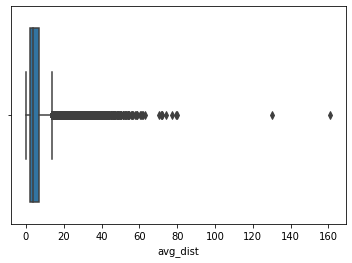

In [40]:
sns.boxplot(df.avg_dist)

In [41]:
df.sort_values('avg_dist', ascending=False)

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver,month,non_rater
20701,Astapor,0,2014-01-25,4.601559,1.0,2014-06-26,Android,0.0,False,100.0,160.96,4.778158,6,1
534,King's Landing,0,2014-01-04,4.601559,1.0,2014-03-09,Unknown,0.0,False,0.0,129.89,5.000000,3,1
1302,Winterfell,1,2014-01-30,5.000000,1.0,2014-01-30,iPhone,0.0,False,100.0,79.69,5.000000,1,0
22290,Astapor,0,2014-01-12,5.000000,1.0,2014-06-26,iPhone,0.0,True,100.0,79.34,5.000000,6,0
47595,King's Landing,0,2014-01-25,5.000000,1.0,2014-06-09,iPhone,0.0,True,0.0,77.13,5.000000,6,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24853,King's Landing,0,2014-01-15,4.601559,1.5,2014-06-25,iPhone,100.0,False,100.0,0.00,5.000000,6,1
23728,Astapor,1,2014-01-29,4.601559,1.0,2014-01-29,Android,0.0,False,100.0,0.00,5.000000,1,1
35726,Winterfell,1,2014-01-05,4.601559,1.0,2014-02-02,iPhone,0.0,False,0.0,0.00,2.000000,2,1
24946,Winterfell,1,2014-01-04,4.601559,1.0,2014-01-05,Android,0.0,False,0.0,0.00,1.000000,1,1


In [42]:
#choosing not to drop these two outliers from avg_dist because the data seems to have been recorded correctly

In [43]:
df['active'] = np.where(df['month'] == 6, 1, 0)

In [44]:
#df['active2'] = np.where(df['last_trip_date'].max() - datetime.timedelta(days=30) <= df['last_trip_date'] and df['last_trip_date'] < df['last_trip_date'].max(), 1, 0)

In [45]:
df['active'].sum()/50000 * 100

36.512

36.51% were retained and are active (based on the definition given: a rider who took a trip in the preceding 30 days)

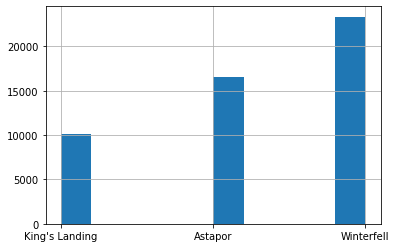

In [46]:
df.city.hist()

In [47]:
last_trip_agg = df.resample('D', on='last_trip_date').size().reset_index(name='last_trip_day_count')

In [48]:
last_trip_agg = last_trip_agg[['last_trip_date', 'last_trip_day_count']]

Text(0.5, 1.0, 'Frequency of trips every day')

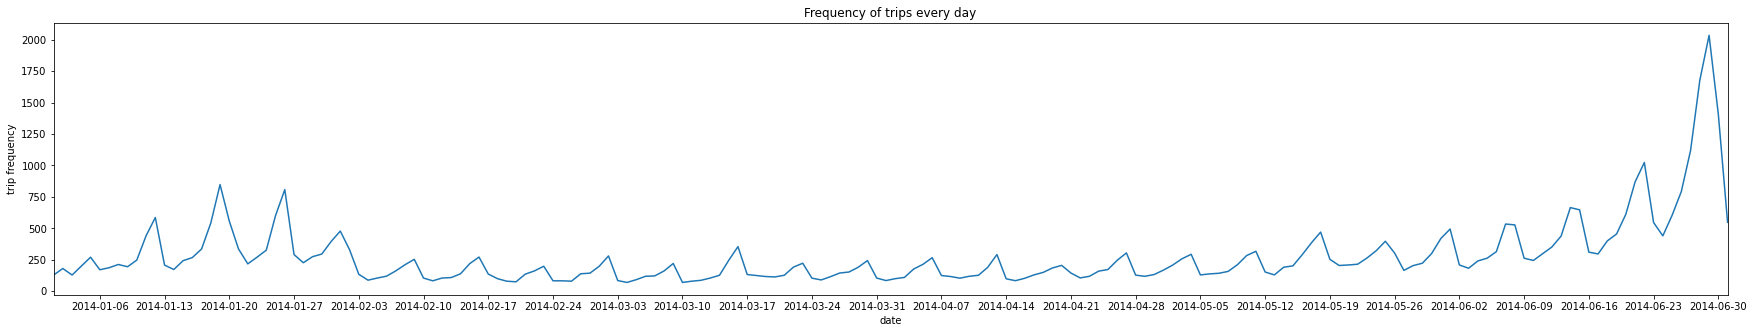

In [49]:
fig, ax = plt.subplots(figsize=(30, 5))
plt.plot('last_trip_date', 'last_trip_day_count', data=last_trip_agg)
ax.xaxis.set_major_locator(mdates.DayLocator(interval=7))
ax.margins(x=0)
ax.set_xlabel('date')
ax.set_ylabel('trip frequency')
plt.title('Frequency of trips every day')

In [50]:
last_trip_nonactive = df.loc[df['active'].isin([0])]
last_trip_nonactive = last_trip_nonactive.resample('D', on='last_trip_date').size().reset_index(name='last_trip_nonactive_day_count')
last_trip_nonactive = last_trip_nonactive[['last_trip_date', 'last_trip_nonactive_day_count']]

Text(0.5, 1.0, 'Frequency of trips every day for nonactive users')

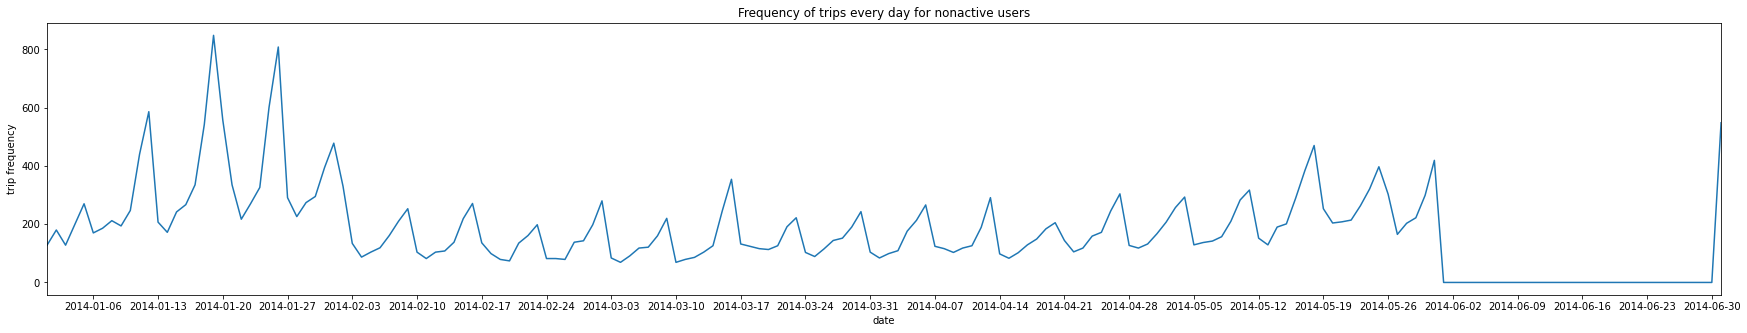

In [51]:
fig, ax = plt.subplots(figsize=(30, 5))
plt.plot('last_trip_date', 'last_trip_nonactive_day_count', data=last_trip_nonactive)
ax.xaxis.set_major_locator(mdates.DayLocator(interval=7))
ax.margins(x=0)
ax.set_xlabel('date')
ax.set_ylabel('trip frequency')
plt.title('Frequency of trips every day for nonactive users')

In [52]:
print(df[df['ultimate_black_user']==True]['avg_rating_by_driver'].mean())
print(df[df['ultimate_black_user']==True]['avg_rating_of_driver'].mean())

4.783502565962799
4.600167850940604


/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


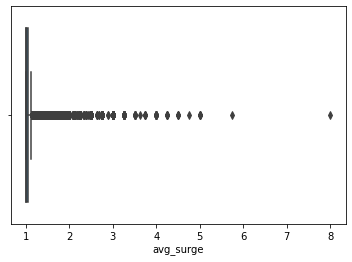

In [53]:
sns.boxplot(df.avg_surge)

In [54]:
df.sort_values('avg_surge', ascending=False).head()

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver,month,non_rater,active
13861,Winterfell,1,2014-01-01,1.000000,8.00,2014-01-01,iPhone,100.0,False,100.0,5.77,5.0,1,0,0
30477,Winterfell,1,2014-01-01,5.000000,5.75,2014-01-01,iPhone,100.0,False,100.0,1.98,5.0,1,0,0
21894,Winterfell,1,2014-01-10,4.601559,5.00,2014-01-11,Android,100.0,False,100.0,2.46,4.0,1,1,0
2817,Winterfell,0,2014-01-02,5.000000,5.00,2014-02-05,iPhone,100.0,False,100.0,3.18,5.0,2,0,0
19191,Winterfell,1,2014-01-10,5.000000,5.00,2014-01-11,Android,100.0,False,100.0,3.37,5.0,1,0,0


(array([4.525e+04, 2.689e+03, 9.020e+02, 4.240e+02, 2.930e+02, 1.410e+02,
        1.040e+02, 5.000e+01, 8.000e+01, 2.300e+01, 9.000e+00, 6.000e+00,
        1.200e+01, 5.000e+00, 0.000e+00, 4.000e+00, 1.000e+00, 5.000e+00,
        0.000e+00, 0.000e+00, 1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 1.000e+00]),
 array([1.        , 1.23333333, 1.46666667, 1.7       , 1.93333333,
        2.16666667, 2.4       , 2.63333333, 2.86666667, 3.1       ,
        3.33333333, 3.56666667, 3.8       , 4.03333333, 4.26666667,
        4.5       , 4.73333333, 4.96666667, 5.2       , 5.43333333,
        5.66666667, 5.9       , 6.13333333, 6.36666667, 6.6       ,
        6.83333333, 7.06666667, 7.3       , 7.53333333, 7.76666667,
        8.        ]),
 <a list of 30 Patch objects>)

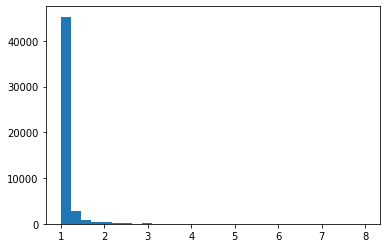

In [55]:
plt.hist('avg_surge', data=df, bins=30)

In [56]:
features = ['city', 'phone', 'avg_dist', 'avg_rating_by_driver', 'avg_rating_of_driver', 'surge_pct', 'avg_surge', 'trips_in_first_30_days', 'ultimate_black_user', 'weekday_pct']

In [57]:
y = df['active']
X = df[features]

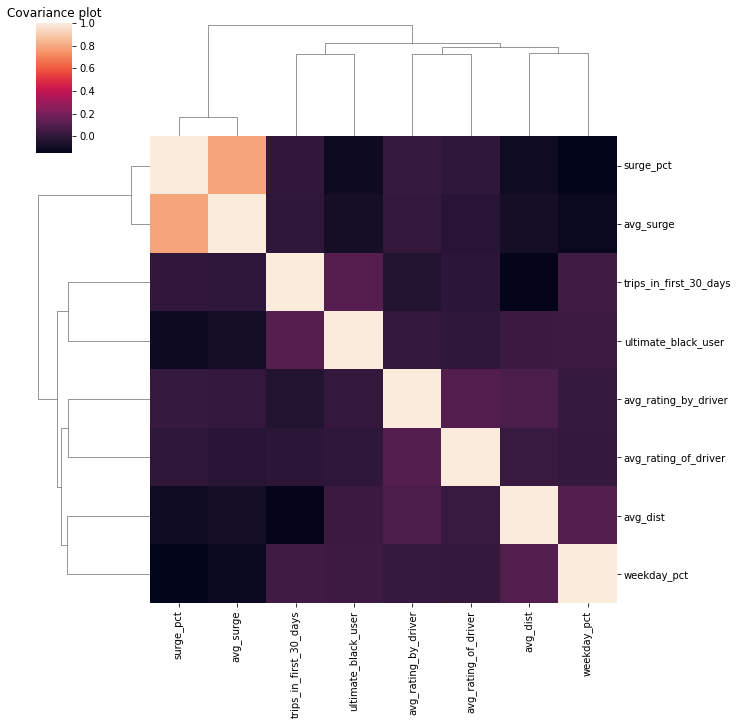

In [58]:
sns.clustermap(X.corr())
plt.title('Covariance plot')
plt.show()

Modeling for Part 3 - Build a predictive model to help Ultimate determine whether or not a user will be active in their 6th month on the system

In [59]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, roc_auc_score, accuracy_score
from sklearn.decomposition import PCA

In [60]:
df.columns

Index(['city', 'trips_in_first_30_days', 'signup_date', 'avg_rating_of_driver',
       'avg_surge', 'last_trip_date', 'phone', 'surge_pct',
       'ultimate_black_user', 'weekday_pct', 'avg_dist',
       'avg_rating_by_driver', 'month', 'non_rater', 'active'],
      dtype='object')

In [61]:
#define independent and independent variables
X = df.drop(['signup_date', 'last_trip_date', 'month', 'active'], axis=1)
y = df['active']

In [62]:
#for categorical data
X_onehot = pd.get_dummies(X)

In [87]:
X_onehot.columns

Index(['trips_in_first_30_days', 'avg_rating_of_driver', 'avg_surge',
       'surge_pct', 'ultimate_black_user', 'weekday_pct', 'avg_dist',
       'avg_rating_by_driver', 'non_rater', 'city_Astapor',
       'city_King's Landing', 'city_Winterfell', 'phone_Android',
       'phone_Unknown', 'phone_iPhone'],
      dtype='object')

In [63]:
#scale
sc_X = StandardScaler()
sc_X = sc_X.fit_transform(X_onehot)

In [64]:
#split data 80% train and 20% test
X_train, X_test, y_train, y_test = train_test_split(sc_X, y, test_size = .2, random_state = 42)

In [65]:
#Decision Tree
clf = DecisionTreeClassifier()
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
accuracy_score(y_test, y_pred)

0.6999

In [66]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.76      0.77      0.76      6313
           1       0.59      0.58      0.59      3687

    accuracy                           0.70     10000
   macro avg       0.68      0.68      0.68     10000
weighted avg       0.70      0.70      0.70     10000



In [67]:
#Random Forest
rfc = RandomForestClassifier(n_estimators=100)
rfc.fit(X_train, y_train)
y_pred = rfc.predict(X_test)
accuracy_score(y_test, y_pred)

0.7464

In [68]:
#Gradient Boosting
gbc = GradientBoostingClassifier(n_estimators=100)
gbc.fit(X_train, y_train)
y_pred = gbc.predict(X_test)
accuracy_score(y_test, y_pred)

0.7787

In [69]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.81      0.85      0.83      6313
           1       0.72      0.65      0.69      3687

    accuracy                           0.78     10000
   macro avg       0.76      0.75      0.76     10000
weighted avg       0.78      0.78      0.78     10000



Recall: If I pick a random actual positive example, what is the probability of it being actually positive 

Precision: If I take a positive prediction example, whats the probability that it is indeed a positive example


For predicting nonactive riders:

  81% of actually nonactive riders were predicted as nonactive

  85% of predicted nonactive riders were predicted correctly

For predicting active riders:

  72%

  65%



...with 78% accuracy

In [ ]:
#confusion matrix

In [70]:
y_pred_prob = gbc.predict_proba(X_test)[:1]
print(y_pred_prob)

[[0.23538024 0.76461976]]


probability of nonactive is .380
probability of active is .620

In [71]:
#AdaBoost
abc = AdaBoostClassifier(n_estimators=100)
abc.fit(X_train, y_train)
y_pred = abc.predict(X_test)
accuracy_score(y_test, y_pred)

0.7747

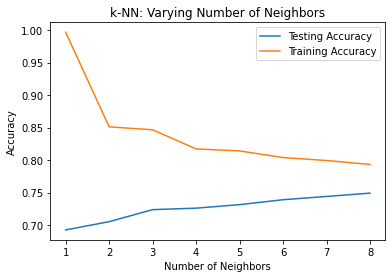

In [72]:
#KNN
neighbors = np.arange(1, 9)
train_accuracy = np.empty(len(neighbors))
test_accuracy = np.empty(len(neighbors))

for i, k in enumerate(neighbors):
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train, y_train)
    train_accuracy[i] = knn.score(X_train, y_train)
    test_accuracy[i] = knn.score(X_test, y_test)

plt.title('k-NN: Varying Number of Neighbors')
plt.plot(neighbors, test_accuracy, label = 'Testing Accuracy')
plt.plot(neighbors, train_accuracy, label = 'Training Accuracy')
plt.legend()
plt.xlabel('Number of Neighbors')
plt.ylabel('Accuracy')
plt.show()

Minimum error:- 0.242 at K = 38


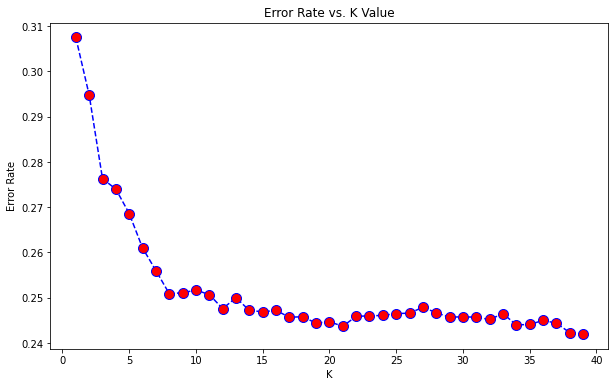

In [73]:
error_rate = []

for i in range(1,40):
  knn = KNeighborsClassifier(n_neighbors=i)
  knn.fit(X_train,y_train)
  y_pred = knn.predict(X_test)
  error_rate.append(np.mean(y_pred != y_test))

plt.figure(figsize=(10,6))
plt.plot(range(1,40),error_rate,color='blue', linestyle='dashed',marker='o',markerfacecolor='red', markersize=10)
plt.title('Error Rate vs. K Value')
plt.xlabel('K')
plt.ylabel('Error Rate')
print("Minimum error:-",min(error_rate),"at K =",error_rate.index(min(error_rate)))

In [74]:
#square root of # of samples
np.sqrt(50000)

223.60679774997897

In [75]:
# k = 224
knn = KNeighborsClassifier(n_neighbors=224)
knn.fit(X_train,y_train)
y_pred = knn.predict(X_test)
accuracy_score(y_test, y_pred)

0.7526

In [88]:
# k = 7
knn = KNeighborsClassifier(n_neighbors=7)
knn.fit(X_train,y_train)
y_pred = knn.predict(X_test)
accuracy_score(y_test, y_pred)

0.744

In [76]:
#Logistic Regression
lrc = LogisticRegression()
lrc.fit(X_train,y_train)
y_pred = lrc.predict(X_test)
accuracy_score(y_test, y_pred)

0.7177

In [77]:
y_pred_prob = lrc.predict_proba(X_test)[:,1]
roc_auc_score(y_test, y_pred_prob)

0.7596956500014971

In [78]:
#SVM
svc = SVC(kernel='linear')
svc.fit(X_train,y_train)
y_pred = svc.predict(X_test)
accuracy_score(y_test, y_pred)

0.695

Overall, the Gradient Boosting model performed the best so we would use this moving forward to predict if future riders will be active or inactive.

Text(0, 0.5, 'Proportion of Variance Explained')

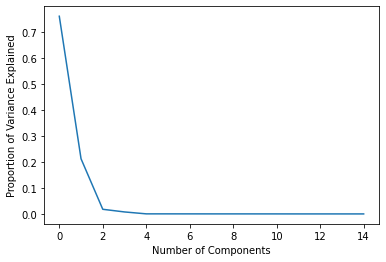

In [79]:
pca = PCA()
pca.fit(X_onehot)

variance = pca.explained_variance_ratio_

plt.plot(range(len(variance)), variance)
plt.xlabel("Number of Components")
plt.ylabel("Proportion of Variance Explained")

In [80]:
pca.n_components_

15

In [82]:
gbc.feature_importances_

array([4.35868976e-02, 1.19120351e-02, 3.84925814e-03, 1.69636753e-01,
       7.33272972e-02, 1.62603630e-01, 1.90546165e-02, 2.33659470e-01,
       1.53047260e-03, 2.74263539e-02, 1.59128598e-01, 1.44274569e-04,
       6.38443071e-02, 0.00000000e+00, 3.02960364e-02])

Text(0.5, 0, 'Gradient Boosting Feature Importance')

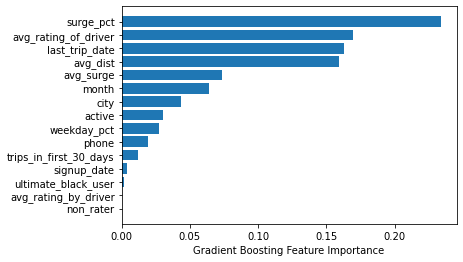

In [89]:
sorted = gbc.feature_importances_.argsort()
plt.barh(df.columns[sorted], gbc.feature_importances_[sorted])
plt.xlabel("Gradient Boosting Feature Importance")